In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
image = cv2.imread('datasets/ADE20K_2021_17_01/images/ADE/training/cultural/apse__indoor/ADE_train_00001472.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

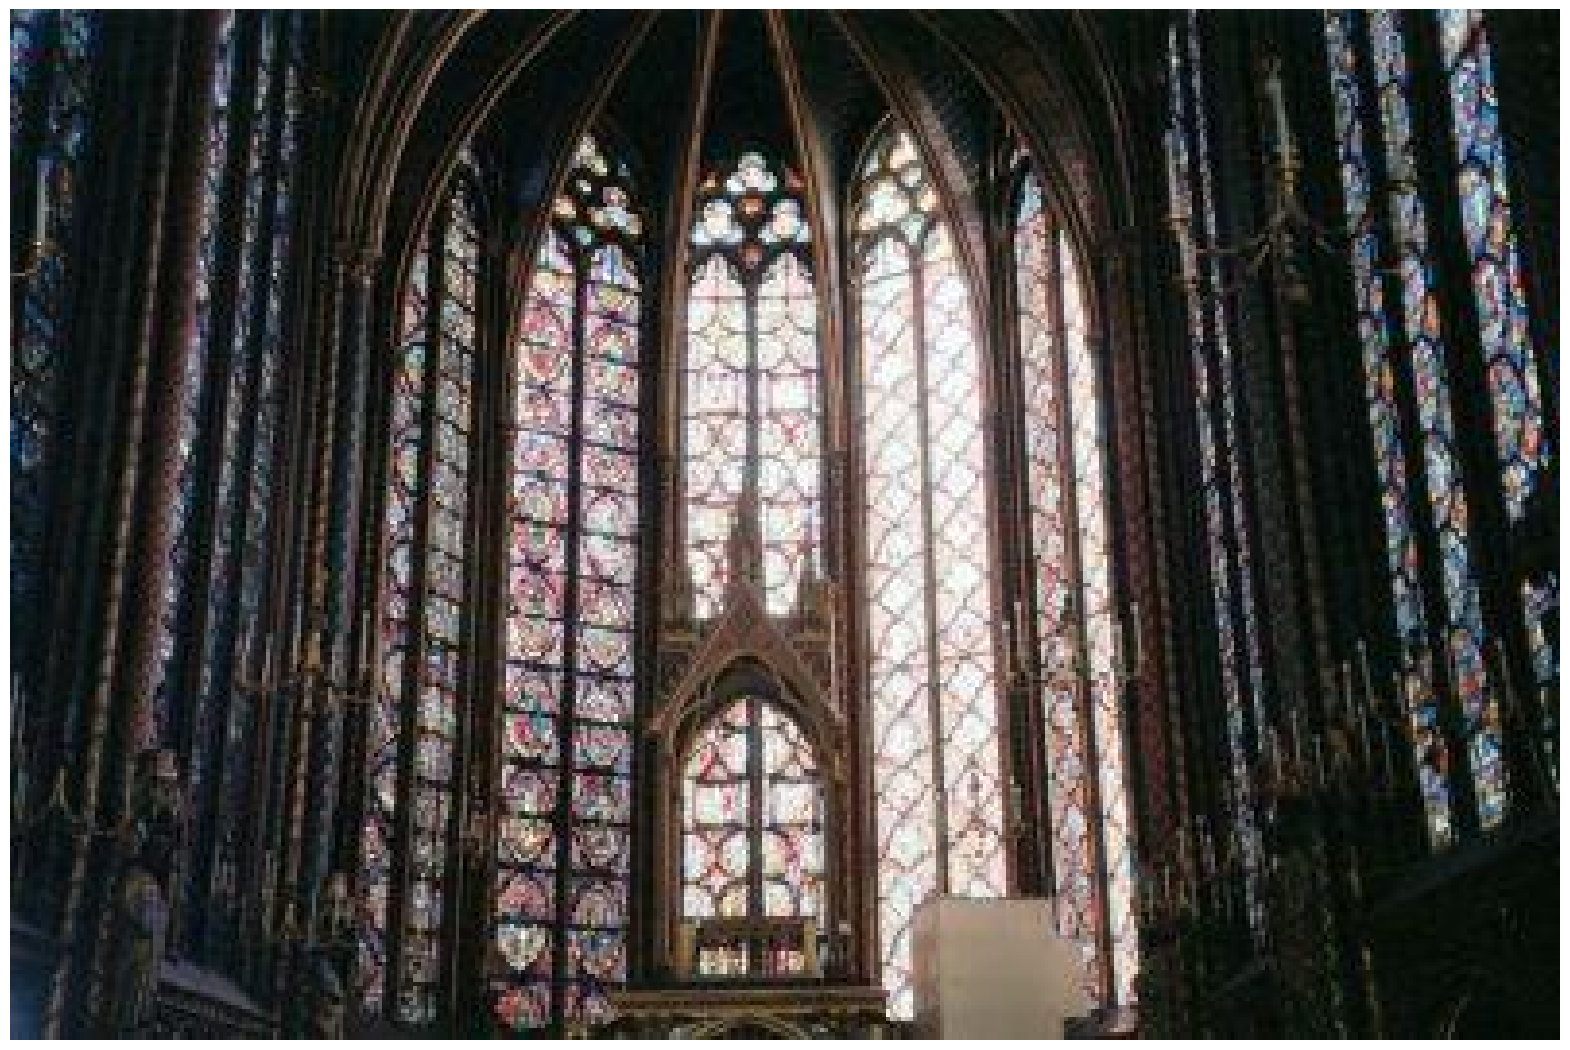

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### SAM 

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=20,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=0,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=400,  # Requires open-cv to run post-processing
)

/home/disi/miniconda3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# AlphaCLIP

In [7]:
from torchvision import transforms

mask_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.26)
])
# alpha = mask_transform(binary_mask * 255)
import alpha_clip
from PIL import Image

# weights = 'checkpoints/clip_b16_grit1m_fultune_8xe.pth'
weights = 'checkpoints/clip_b16_grit+mim_fultune_4xe.pth'
device = 'cuda'
model, preprocess = alpha_clip.load("ViT-B/16", weights, device=device)
# image_features = model.visual(image, alpha)

/home/disi/VF-SemanticSegmentation/AlphaCLIP/alpha_clip/alpha_clip.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.visual.load_state_dict(torch.load(alpha_vision

In [8]:
masks = mask_generator.generate(image)

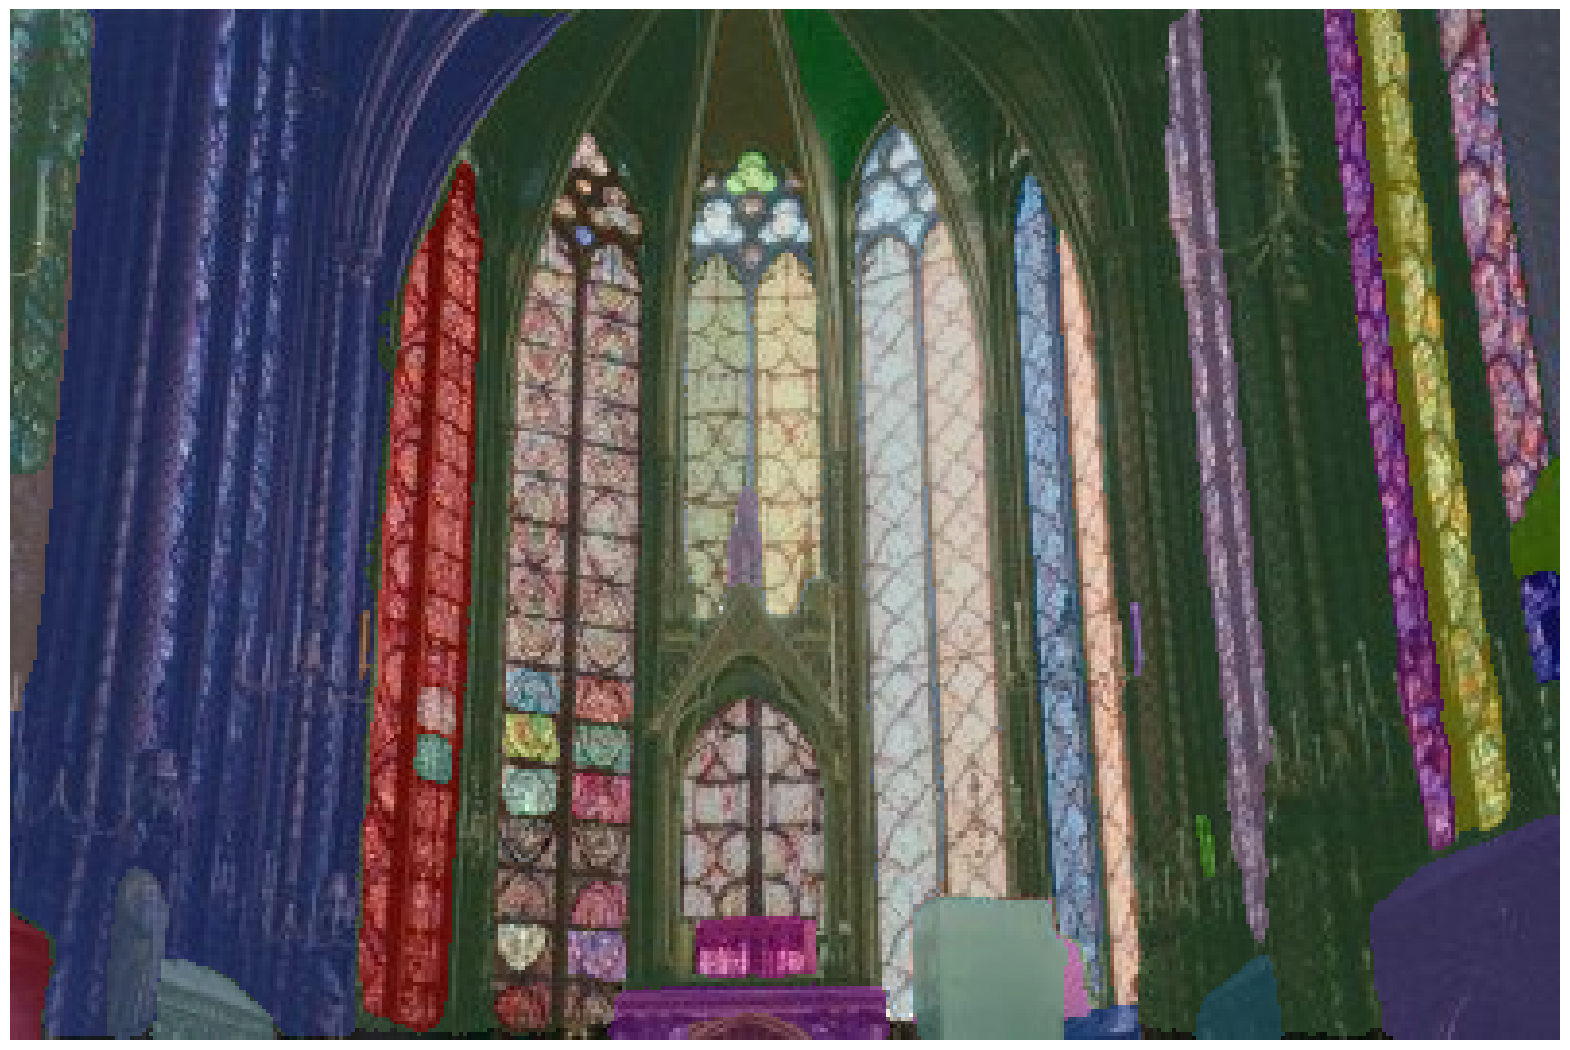

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

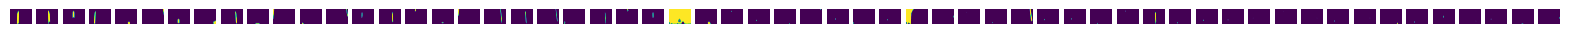

In [10]:
# Create a smaller subplot showing every mask in separate images
fig, axs = plt.subplots(1, len(masks), figsize=(20,20))
for i, mask in enumerate(masks):
    axs[i].imshow(mask['segmentation'])
    axs[i].axis('off')
plt.show()

In [11]:
def add_padding(bbox, image_shape, padding_p):
    """
    :param bbox: [x, y, w, h]
    :param image_shape: (height, width, channels)
    :param padding_p: padding percentage
    """
    x, y, w, h = bbox
    im_height, im_width, _ = image_shape
    padding = int(padding_p * max(w, h))

    y1 = max(0, y - padding)
    x1 = max(0, x - padding)
 
    new_height = im_height - y1 if h + 2 * padding > im_height else h + 2 * padding
    new_width = im_width - x1 if w + 2 * padding > im_width else w + 2 * padding
    
    if new_height == new_width:
        return x1, y1, new_height, new_width
    elif new_height > new_width:
        diff = new_height - new_width
        x1 = max(0, x1 - diff // 2)
        new_width = new_height
        return x1, y1, new_height, new_width
    else:
        diff = new_width - new_height
        y1 = max(0, y1 - diff // 2)
        new_height = new_width
        return x1, y1, new_height, new_width

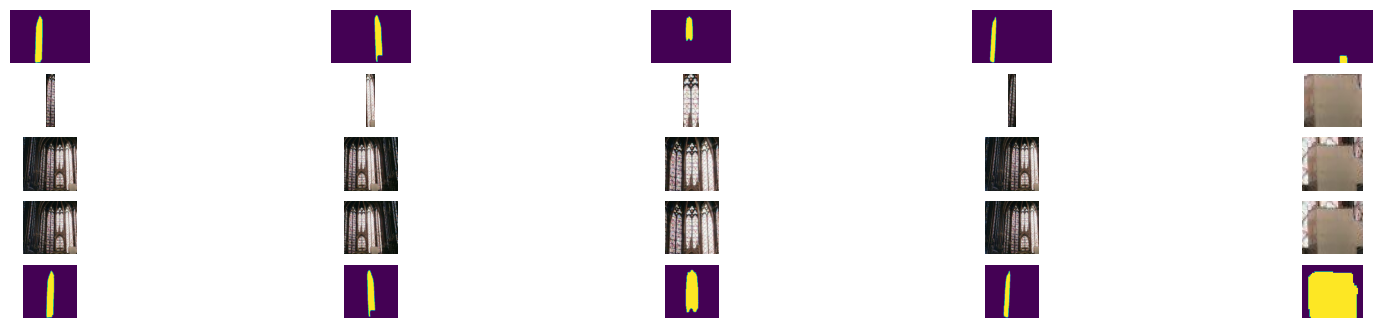

In [12]:
fig, axs = plt.subplots(5, len(masks[:5]), figsize=(20,4))
for i, mask in enumerate(masks[:5]):
    x, y, w, h = mask['bbox']
    axs[0, i].imshow(mask['segmentation'])
    axs[0, i].axis('off')
    axs[1, i].imshow(image[y:y+h, x:x+w])
    axs[1, i].axis('off')
    x1, y1, h1, w1 = add_padding((x, y, w, h), image.shape, 0.15)
    axs[2, i].imshow(image[y1:y1+h1, x1:x1+w1])
    axs[2, i].axis('off')
    
    axs[3, i].imshow(image[y1:y1+h1, x1:x1+w1])
    axs[3, i].axis('off')

    axs[4, i].imshow(mask['segmentation'][y1:y1+h1, x1:x1+w1])
    axs[4, i].axis('off')
plt.show()

## AlphaCLIP Integration


In [13]:
# Pepare vocabulary with COCO
from datasets.dataset_vars import (
        COCO_CATEGORIES, 
        ADE20K_SEM_SEG_FULL_CATEGORIES as ADE20K_CATEGORIES
)
from typing import List
import math

# Take vocabulary and mer with the default COCO vocabulary
def merge_vocabulary_COCO(vocabulary: List[str]) -> List[str]:
        default_voc = []
        for c in COCO_CATEGORIES:
            default_voc.extend(c["name"].split(", "))
        return vocabulary + [c for c in default_voc if c not in vocabulary]

def merge_vocabulary_ADE20K(vocabulary: List[str]) -> List[str]:
        default_voc = []
        for c in ADE20K_CATEGORIES:
            # default_voc.extend(c["name"].split(", "))
            # lst = c["name"].split(", ")
            # default_voc.extend(lst[0]) if len(lst) > 1 else default_voc.extend(c["name"])
            
            tmp = c["name"] + ", a"
            default_voc.append(c["name"].split(", ")[0])

        return vocabulary + [c for c in default_voc if c not in vocabulary]

def take_vocabulary(vocabulary):
    vocabulary = list(set([v.lower().strip() for v in vocabulary]))
    # remove invalid vocabulary
    vocabulary = [v for v in vocabulary if v != ""]

    vocabulary = merge_vocabulary_COCO(vocabulary)

    return vocabulary

def prepare_batch(image, masks, mask_transform, preprocess, prompts):
    imgs = []
    alphas = []
    tokenized_prompts = alpha_clip.tokenize(prompts)

    for mask in masks:        
        x, y, w, h = mask['bbox']
        binary_mask = mask['segmentation'][y:y+h, x:x+w]
        
        alpha = mask_transform((binary_mask * 255).astype(np.uint8))
        alpha = alpha.half().cuda()
        
        cropped_img = image[y:y+h, x:x+w]
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = preprocess(cropped_img).half()

        imgs.append(cropped_img)
        alphas.append(alpha)

    batch = {
        'image': torch.stack(imgs),
        'alpha': torch.stack(alphas),
        'text': tokenized_prompts
    }
        
    return batch

def inference(batch, model, device='cuda'):
    cropped_img, alpha, tokenized_prompts = batch['image'], batch['alpha'], batch['text']
    
    cropped_img = cropped_img.to(device)
    alpha = alpha.to(device)
    text = tokenized_prompts.to(device)

    with torch.no_grad():
        image_features = model.visual(cropped_img, alpha)
        text_features = model.encode_text(text) 

    # normalize
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits_scale = math.exp(1.2) # TODO Consider whether to keep this
    similarity = (logits_scale * 100.0 * image_features @ text_features.T).softmax(dim=-1)

    return similarity

def prompts_from_vocab(vocabulary):
    return [f"a photo of a {v}" for v in vocabulary]

In [14]:
base_vocab = []
vocabulary = merge_vocabulary_ADE20K(base_vocab)
prompts = prompts_from_vocab(vocabulary)
batch = prepare_batch(image, masks, mask_transform, preprocess, prompts)
logits = inference(batch, model, device)

predictions = logits.argmax(dim=-1)
values, indices = logits.cpu().topk(5)

for dim in range(len(values)):
    print("\n\nTop 5 predictions for mask ", dim)
    for value, index in zip(values[dim], indices[dim]):
        print(f"\t{vocabulary[index]}: {value.item()}")



Top 5 predictions for mask  0
	windowpane: 0.88525390625
	pane: 0.087646484375
	garland: 0.007656097412109375
	grille door: 0.004100799560546875
	trellis: 0.0038509368896484375


Top 5 predictions for mask  1
	windowpane: 0.8134765625
	pane: 0.1505126953125
	cross: 0.0168914794921875
	grille door: 0.01399993896484375
	screen door: 0.0020160675048828125


Top 5 predictions for mask  2
	windowpane: 0.970703125
	pane: 0.0275421142578125
	cross: 0.001003265380859375
	panel: 0.00023829936981201172
	grille door: 0.00023829936981201172


Top 5 predictions for mask  3
	vending machine: 0.1549072265625
	slot machine: 0.13671875
	pigeonhole: 0.1064453125
	bookcase: 0.10003662109375
	shops: 0.09393310546875


Top 5 predictions for mask  4
	cardboard: 0.292724609375
	paper towel: 0.2142333984375
	toilet: 0.03497314453125
	towel paper: 0.0308685302734375
	countertop: 0.02899169921875


Top 5 predictions for mask  5
	person: 0.252197265625
	fluorescent: 0.1845703125
	blind: 0.162841796875
	videos:

/tmp/ipykernel_43818/3718101931.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(masks))


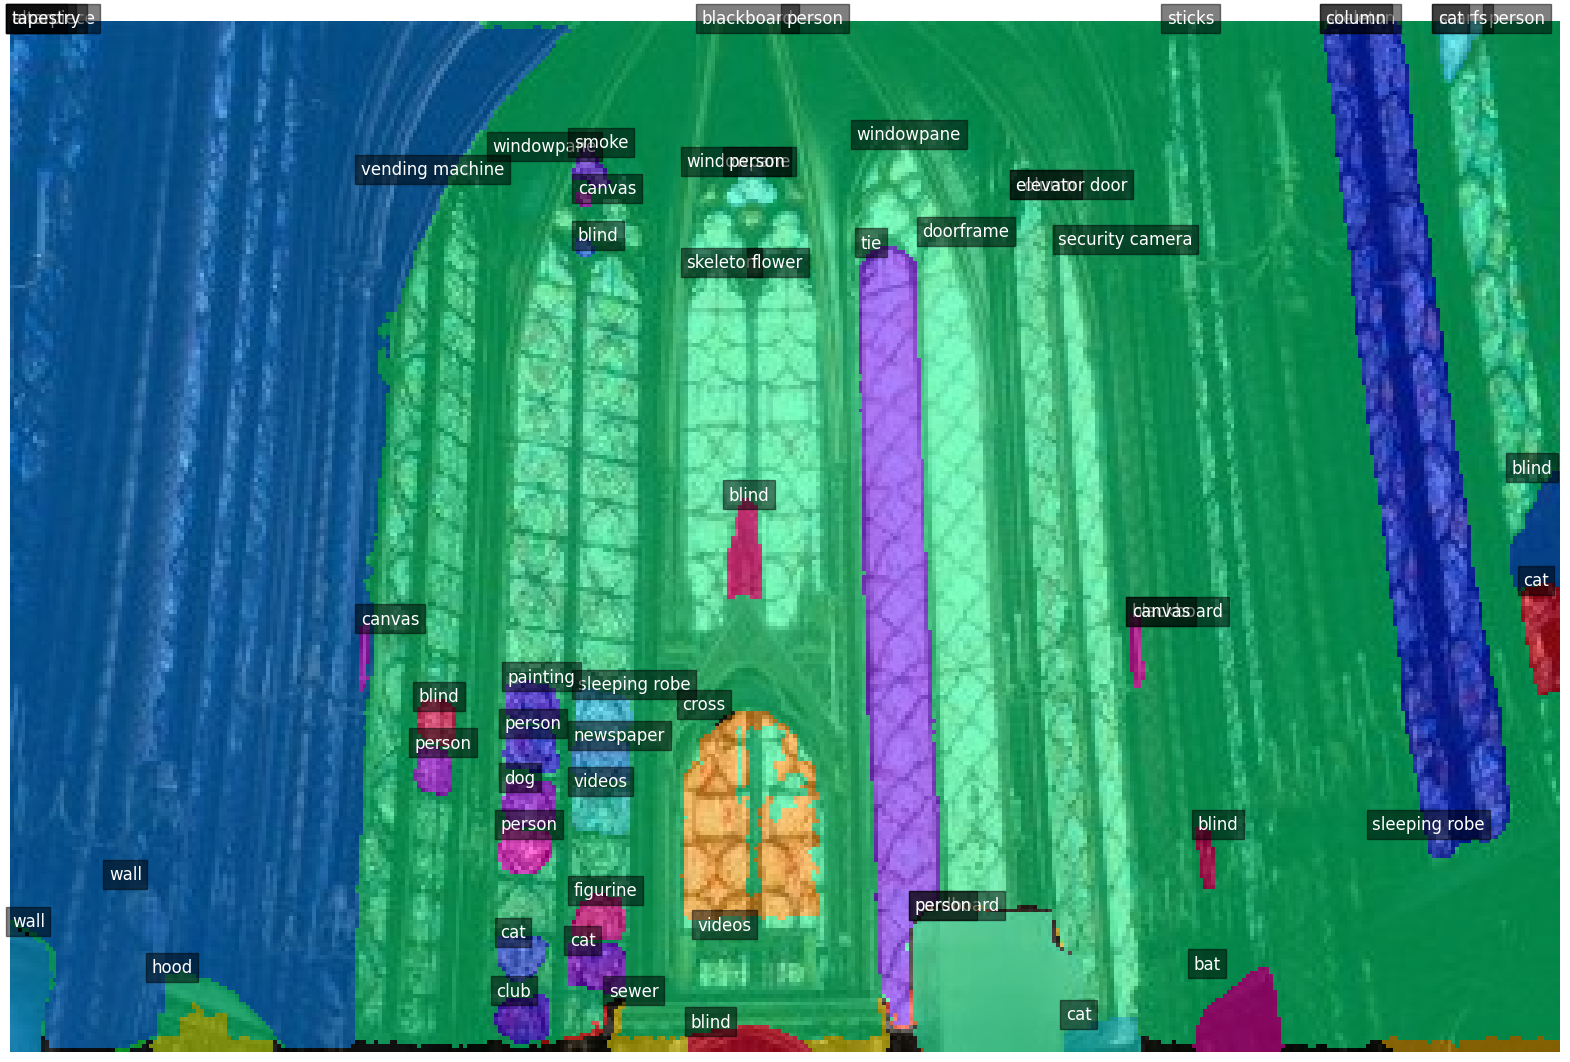

In [15]:
# Create a blank image with the same shape as the original image
recomposed_image = np.zeros_like(image)

# Define a list of colors for the masks
colors = plt.cm.get_cmap('hsv', len(masks))

# Iterate over the masks and apply the colors
for i, mask in enumerate(masks):
    color = colors(i)[:3]  # Get the RGB values from the colormap
    segmentation = mask['segmentation']
    recomposed_image[segmentation] = (np.array(color) * 255).astype(np.uint8)

# Overlay the recomposed image on the original image
overlay_image = cv2.addWeighted(image, 0.5, recomposed_image, 0.5, 0)

# Plot the overlay image with the top 1 prediction labels
plt.figure(figsize=(20, 20))
plt.imshow(overlay_image)
for i, mask in enumerate(masks):
    x, y, w, h = mask['bbox']
    plt.text(x, y, vocabulary[predictions[i]], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
plt.axis('off')
plt.show()

/tmp/ipykernel_43818/642491835.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(masks))


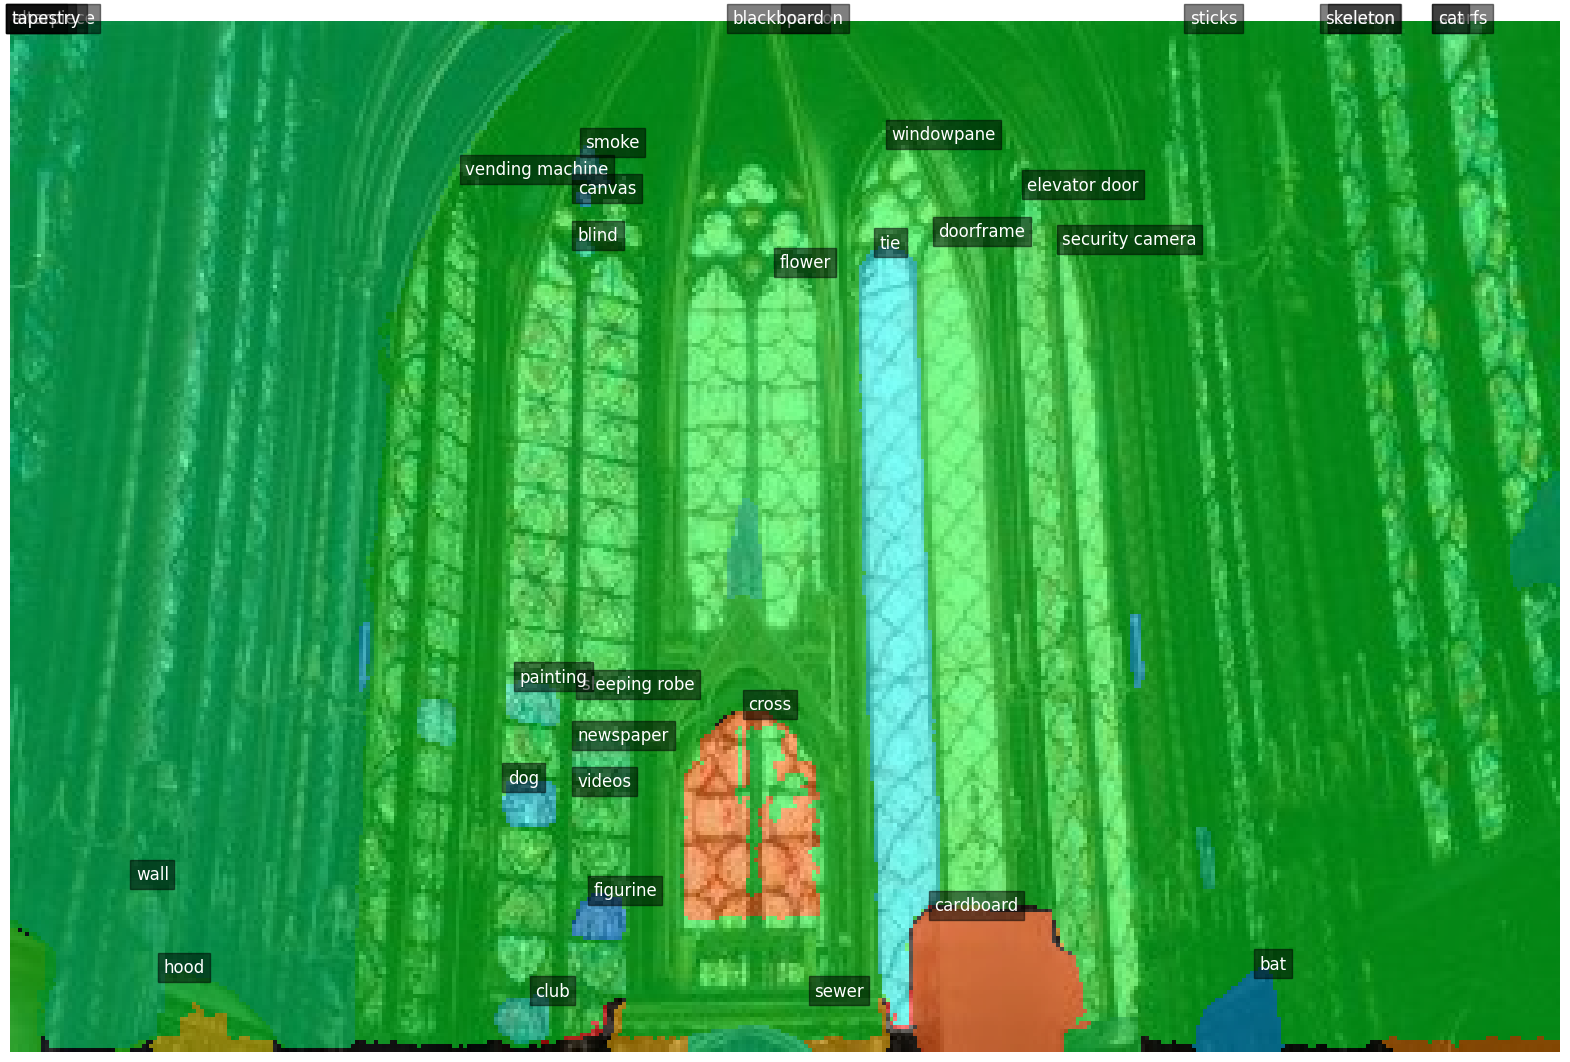

In [16]:
import numpy as np
import cv2

# Create a blank image with the same shape as the original image
recomposed_image = np.zeros_like(image)

# Define a list of colors for the masks
colors = plt.cm.get_cmap('hsv', len(masks))

# Create a dictionary to store combined masks for each label
combined_masks = {}

# Iterate over the masks and combine adjacent masks with the same label
for i, mask in enumerate(masks):
    label = vocabulary[predictions[i]]
    if label not in combined_masks:
        combined_masks[label] = np.zeros_like(mask['segmentation'], dtype=bool)
    combined_masks[label] = np.logical_or(combined_masks[label], mask['segmentation'])

# Apply the colors to the combined masks
for i, (label, combined_mask) in enumerate(combined_masks.items()):
    color = colors(i)[:3]  # Get the RGB values from the colormap
    recomposed_image[combined_mask] = (np.array(color) * 255).astype(np.uint8)

# Overlay the recomposed image on the original image
overlay_image = cv2.addWeighted(image, 0.5, recomposed_image, 0.5, 0)

# Plot the overlay image with the top 1 prediction labels
plt.figure(figsize=(20, 20))
plt.imshow(overlay_image)
for label, combined_mask in combined_masks.items():
    y, x = np.where(combined_mask)
    if len(y) > 0 and len(x) > 0:
        plt.text(x[0], y[0], label, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
plt.axis('off')
plt.show()